In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pathlib
import numpy as np
import pandas as pd

In [3]:
DATA_DIR = pathlib.Path("./phm_data_challenge_2018/")

# Data description

Challenge description is available at:

https://www.phmsociety.org/events/conference/phm/18/data-challenge

We will use tool `03M02`, as it contains enough faults of various types.

# Loading data

In [4]:
features = pd.read_csv(DATA_DIR / "train" / "03_M02_DC_train.csv", index_col="time")

/home/traveller/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
features.head()

,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,ETCHSUPPRESSORVOLTAGE,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
time,,,,,,,,,,,,,,,,,,,,,
3284714,03M02,1,640,10511726,249,1,-1.547961,-1.222222,-1.272007,-1.468476,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975
3284720,03M02,1,640,10511726,249,1,-1.547446,-1.221113,-1.272404,-1.468567,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975
3284722,03M02,1,640,10511726,249,1,-1.546922,-1.221020,-1.272007,-1.468522,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975
3284726,03M02,1,640,10511726,249,1,-1.547770,-1.221205,-1.271928,-1.468567,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975
3284730,03M02,1,640,10511726,249,1,-1.548045,-1.222407,-1.271769,-1.468522,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975


In [6]:
faults = pd.read_csv(DATA_DIR / "train" / "train_faults" / "03_M02_train_fault_data.csv")

In [7]:
faults = faults.drop_duplicates()

In [8]:
faults

,time,fault_name,Tool
0,3326152,FlowCool Pressure Dropped Below Limit,03M02
1,3780688,FlowCool Pressure Dropped Below Limit,03M02
2,3961378,FlowCool Pressure Dropped Below Limit,03M02
3,4528896,FlowCool Pressure Dropped Below Limit,03M02
5,4984318,Flowcool Pressure Too High Check Flowcool Pump,03M02
...,...,...,...
356,41424508,Flowcool Pressure Too High Check Flowcool Pump,03M02
357,42277232,Flowcool Pressure Too High Check Flowcool Pump,03M02
358,42365550,Flowcool Pressure Too High Check Flowcool Pump,03M02
359,42399838,Flowcool Pressure Too High Check Flowcool Pump,03M02


Text(0, 0.5, '# of events')

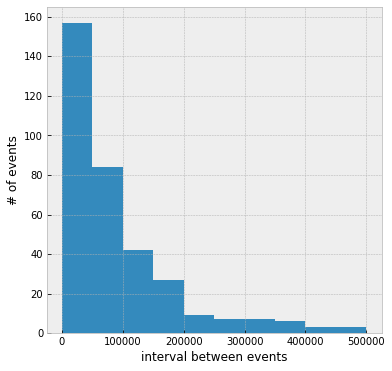

In [9]:
plt.figure(figsize=(6,6))
faults.time.diff().plot(kind="hist", range=(0, 5e5), bins=10)
plt.xlabel("interval between events")
plt.ylabel("# of events")

In [10]:
faults.fault_name.value_counts()

FlowCool Pressure Dropped Below Limit                         298
Flowcool Pressure Too High Check Flowcool Pump                 48
Flowcool leak                                                   9
Flowcool Pressure Too High Check Flowcool Pump [NoWaferID]      1
Name: fault_name, dtype: int64

In [11]:
faults.iloc[1:]["fault_name"]=="FlowCool Pressure Dropped Below Limit"

1       True
2       True
3       True
5      False
7       True
       ...  
356    False
357    False
358    False
359    False
360    False
Name: fault_name, Length: 355, dtype: bool

In [12]:
ttes = faults[["time"]].diff().iloc[1:]
ttes["observed"] = faults.iloc[1:]["fault_name"]=="FlowCool Pressure Dropped Below Limit"

In [13]:
ttes.head()

,time,observed
1,454536.0,True
2,180690.0,True
3,567518.0,True
5,455422.0,False
7,92072.0,True


In [14]:
faults.head()

,time,fault_name,Tool
0,3326152,FlowCool Pressure Dropped Below Limit,03M02
1,3780688,FlowCool Pressure Dropped Below Limit,03M02
2,3961378,FlowCool Pressure Dropped Below Limit,03M02
3,4528896,FlowCool Pressure Dropped Below Limit,03M02
5,4984318,Flowcool Pressure Too High Check Flowcool Pump,03M02


# Basic test - no discrimination between failures

In [15]:
import lifelines
from lifelines.plotting import qq_plot

In [16]:
model_wb_all = lifelines.WeibullFitter()
model_exp_all = lifelines.ExponentialFitter()
model_ln_all = lifelines.LogNormalFitter()
model_ll_all = lifelines.LogLogisticFitter()

model_wb_all.fit(durations=ttes["time"])
model_exp_all.fit(durations=ttes["time"])
model_ln_all.fit(durations=ttes["time"])
model_ll_all.fit(durations=ttes["time"])

<lifelines.LogLogisticFitter:"LogLogistic_estimate", fitted with 355 total observations, 0 right-censored observations>

In [17]:
model_wb_all.print_summary()

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 355 total observations, 0 right-censored observations>
   number of observations = 355
number of events observed = 355
           log-likelihood = -4467.95
               hypothesis = lambda_ != 1, rho_ != 1

---
            coef   se(coef)   coef lower 95%   coef upper 95%     z      p   -log2(p)
lambda_ 98003.55    6982.39         84318.33        111688.77 14.04 <0.005     146.25
rho_        0.79       0.03             0.73             0.85 -6.98 <0.005      38.33
---
AIC = 8939.89

In [18]:
model_exp_all.print_summary()

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 355 total observations, 0 right-censored observations>
   number of observations = 355
number of events observed = 355
           log-likelihood = -4490.32
               hypothesis = lambda_ != 1

---
             coef   se(coef)   coef lower 95%   coef upper 95%     z      p   -log2(p)
lambda_ 114552.84    6079.83        102636.59        126469.10 18.84 <0.005     260.64
---
AIC = 8982.64

In [19]:
model_ll_all.print_summary()

<lifelines.LogLogisticFitter:"LogLogistic_estimate", fitted with 355 total observations, 0 right-censored observations>
   number of observations = 355
number of events observed = 355
           log-likelihood = -4472.38
               hypothesis = alpha_ != 1, beta_ != 1

---
           coef   se(coef)   coef lower 95%   coef upper 95%     z      p   -log2(p)
alpha_ 56039.07    4072.47         48057.17         64020.96 13.76 <0.005     140.70
beta_      1.25       0.06             1.14             1.36  4.44 <0.005      16.76
---
AIC = 8948.76

In [20]:
model_ln_all.print_summary()

<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 355 total observations, 0 right-censored observations>
   number of observations = 355
number of events observed = 355
           log-likelihood = -4487.33
               hypothesis = mu_ != 0, sigma_ != 1

---
         coef   se(coef)   coef lower 95%   coef upper 95%      z      p   -log2(p)
mu_     10.80       0.08            10.64            10.96 133.77 <0.005        inf
sigma_   1.52       0.06             1.41             1.63   9.13 <0.005      63.69
---
AIC = 8978.66

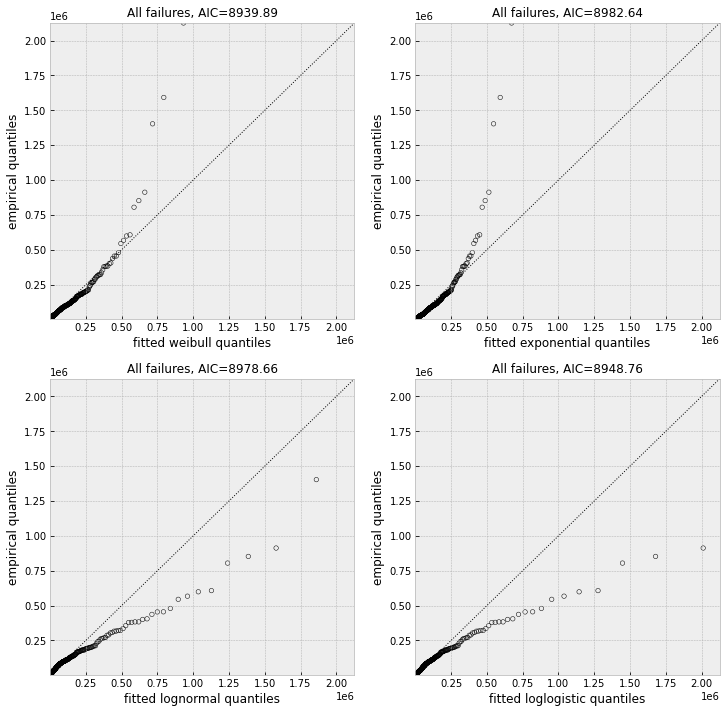

In [21]:
plt.figure(figsize=(12,12))

for i, (model_name, model) in enumerate(zip(["Weibull", "exponential", "log-normal", "log-logistic"],
                                            [model_wb_all, model_exp_all, model_ln_all, model_ll_all])):
    plt.subplot(2,2,i+1)
    qq_plot(model, label="Weibull", ax=plt.gca())
    plt.title(f"All failures, AIC={model.AIC_:.2f}", fontsize=12)
plt.show()

Text(0, 0.5, 'PDF')

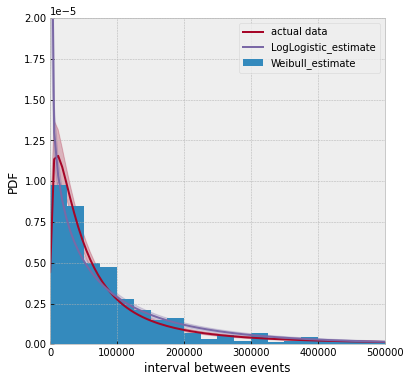

In [22]:
plt.figure(figsize=(6,6))

ttes["time"].plot(kind="hist", density=True, range=(0, 5e5), bins=20, label="actual data", legend=True)
model_ll_all.plot_density()
model_wb_all.plot_density()

plt.xlim(0, 5e5)
plt.ylim(0, 2e-5)

plt.xlabel("interval between events")
plt.ylabel("PDF")

(0.0, 200000.0)

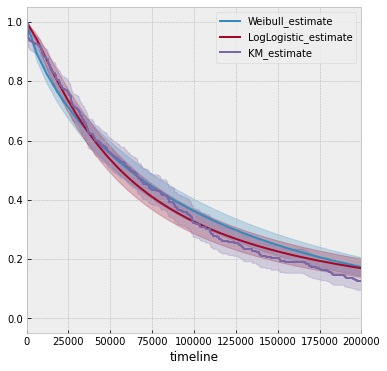

In [23]:
kmf_all = lifelines.KaplanMeierFitter()
kmf_all.fit(durations=ttes["time"])

plt.figure(figsize=(6,6))
model_wb_all.plot_survival_function()
model_ll_all.plot_survival_function()
kmf_all.plot_survival_function()
plt.xlim(0, 2e5)

# Advanced - `FlowCool Pressure Dropped Below Limit` only

In [24]:
model_wb = lifelines.WeibullFitter()
model_exp = lifelines.ExponentialFitter()
model_ln = lifelines.LogNormalFitter()
model_ll = lifelines.LogLogisticFitter()

In [25]:
model_wb.fit(durations=ttes["time"], event_observed=ttes["observed"])
model_exp.fit(durations=ttes["time"], event_observed=ttes["observed"])
model_ln.fit(durations=ttes["time"], event_observed=ttes["observed"])
model_ll.fit(durations=ttes["time"], event_observed=ttes["observed"])

<lifelines.LogLogisticFitter:"LogLogistic_estimate", fitted with 355 total observations, 58 right-censored observations>

In [26]:
model_wb.print_summary()

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 355 total observations, 58 right-censored observations>
   number of observations = 355
number of events observed = 297
           log-likelihood = -3801.22
               hypothesis = lambda_ != 1, rho_ != 1

---
             coef   se(coef)   coef lower 95%   coef upper 95%     z      p   -log2(p)
lambda_ 126877.30    8903.26        109427.23        144327.36 14.25 <0.005     150.66
rho_         0.85       0.03             0.78             0.92 -4.22 <0.005      15.32
---
AIC = 7606.45

In [27]:
model_exp.print_summary()

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 355 total observations, 58 right-censored observations>
   number of observations = 355
number of events observed = 297
           log-likelihood = -3809.67
               hypothesis = lambda_ != 1

---
             coef   se(coef)   coef lower 95%   coef upper 95%     z      p   -log2(p)
lambda_ 136923.43    7945.10        121351.31        152495.55 17.23 <0.005     218.67
---
AIC = 7621.34

In [28]:
model_ln.print_summary()

<lifelines.LogNormalFitter:"LogNormal_estimate", fitted with 355 total observations, 58 right-censored observations>
   number of observations = 355
number of events observed = 297
           log-likelihood = -3771.64
               hypothesis = mu_ != 0, sigma_ != 1

---
         coef   se(coef)   coef lower 95%   coef upper 95%      z      p   -log2(p)
mu_     11.18       0.07            11.04            11.31 166.16 <0.005        inf
sigma_   1.20       0.05             1.10             1.30   4.04 <0.005      14.20
---
AIC = 7547.28

In [29]:
model_ll.print_summary()

<lifelines.LogLogisticFitter:"LogLogistic_estimate", fitted with 355 total observations, 58 right-censored observations>
   number of observations = 355
number of events observed = 297
           log-likelihood = -3763.05
               hypothesis = alpha_ != 1, beta_ != 1

---
           coef   se(coef)   coef lower 95%   coef upper 95%     z      p   -log2(p)
alpha_ 70383.22    4505.77         61552.09         79214.36 15.62 <0.005     180.31
beta_      1.51       0.07             1.37             1.65  7.02 <0.005      38.71
---
AIC = 7530.10

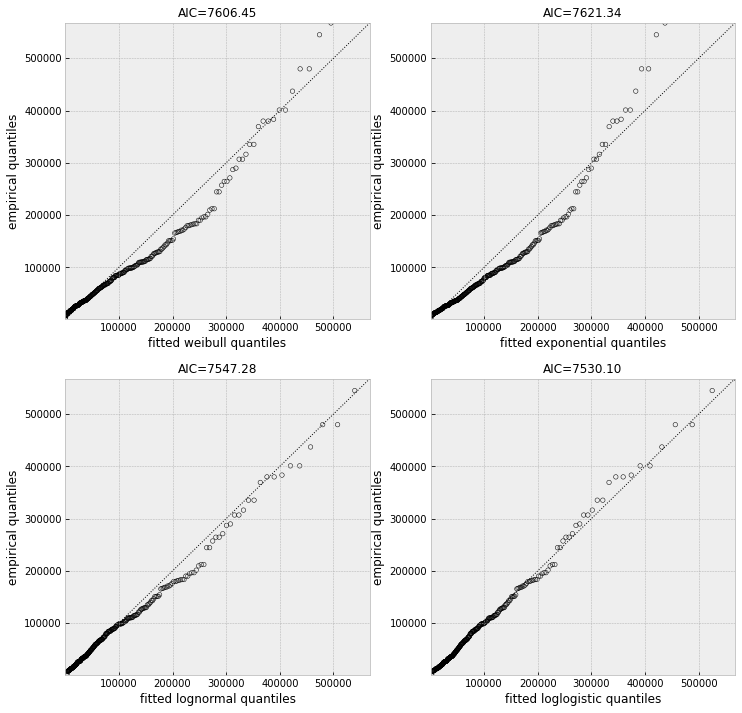

In [30]:
plt.figure(figsize=(12,12))

for i, (model_name, model) in enumerate(zip(["Weibull", "exponential", "log-normal", "log-logistic"],
                                            [model_wb, model_exp, model_ln, model_ll])):
    plt.subplot(2,2,i+1)
    qq_plot(model, label="Weibull", ax=plt.gca())
    plt.title(f"AIC={model.AIC_:.2f}", fontsize=12)
plt.show()

# Visualizing log-logistic distribution

Text(0, 0.5, 'PDF')

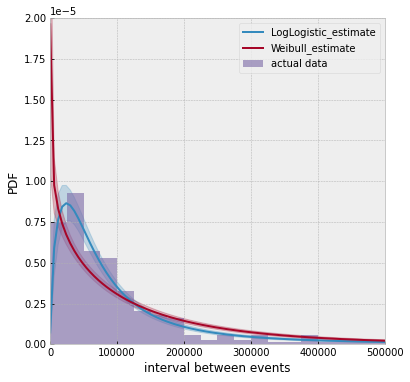

In [31]:
plt.figure(figsize=(6,6))


model_ll.plot_density()
model_wb.plot_density()
ttes.loc[ttes.observed, "time"].plot(kind="hist", density=True, range=(0, 5e5), bins=20, label="actual data", legend=True, alpha=0.6)

plt.xlim(0, 5e5)
plt.ylim(0, 2e-5)

plt.xlabel("interval between events")
plt.ylabel("PDF")

In [32]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(durations=ttes["time"], event_observed=ttes["observed"])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 355 total observations, 58 right-censored observations>

(0.0, 300000.0)

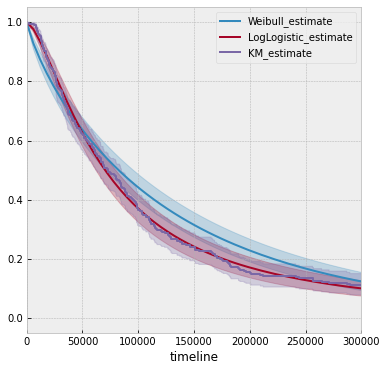

In [33]:
plt.figure(figsize=(6,6))
model_wb.plot_survival_function()
model_ll.plot_survival_function()
kmf.plot_survival_function()
plt.xlim(0, 3e5)

(0.0, 300000.0)

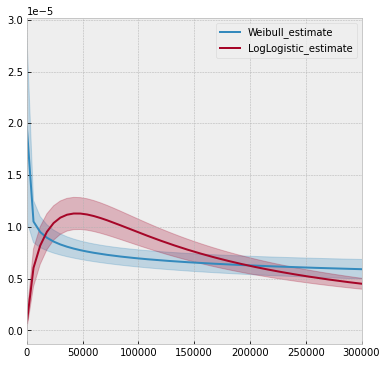

In [34]:
plt.figure(figsize=(6,6))
model_wb.plot_hazard()
model_ll.plot_hazard()

plt.xlim(0, 3e5)

(0.0, 300000.0)

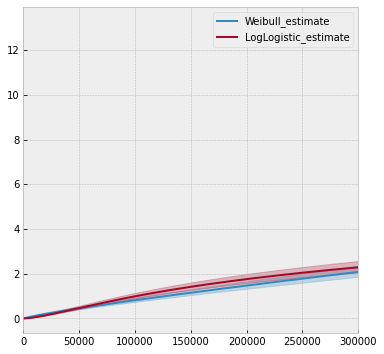

In [35]:
plt.figure(figsize=(6,6))
model_wb.plot_cumulative_hazard()
model_ll.plot_cumulative_hazard()

plt.xlim(0, 3e5)

# Cox proportional hazards model

In [36]:
WINDOW_WIDTH = 10000
NUM_SAMPLES = 5000

In [37]:
faults

,time,fault_name,Tool
0,3326152,FlowCool Pressure Dropped Below Limit,03M02
1,3780688,FlowCool Pressure Dropped Below Limit,03M02
2,3961378,FlowCool Pressure Dropped Below Limit,03M02
3,4528896,FlowCool Pressure Dropped Below Limit,03M02
5,4984318,Flowcool Pressure Too High Check Flowcool Pump,03M02
...,...,...,...
356,41424508,Flowcool Pressure Too High Check Flowcool Pump,03M02
357,42277232,Flowcool Pressure Too High Check Flowcool Pump,03M02
358,42365550,Flowcool Pressure Too High Check Flowcool Pump,03M02
359,42399838,Flowcool Pressure Too High Check Flowcool Pump,03M02


In [38]:
sessions = pd.concat([faults.iloc[:-1].rename(lambda cl: f"{cl}_left", axis=1).reset_index(drop=True),
                      faults.iloc[1:].rename(lambda cl: f"{cl}_right", axis=1).reset_index(drop=True)],
                     axis=1).drop(columns=["Tool_left", "Tool_right"])

In [39]:
sessions

,time_left,fault_name_left,time_right,fault_name_right
0,3326152,FlowCool Pressure Dropped Below Limit,3780688,FlowCool Pressure Dropped Below Limit
1,3780688,FlowCool Pressure Dropped Below Limit,3961378,FlowCool Pressure Dropped Below Limit
2,3961378,FlowCool Pressure Dropped Below Limit,4528896,FlowCool Pressure Dropped Below Limit
3,4528896,FlowCool Pressure Dropped Below Limit,4984318,Flowcool Pressure Too High Check Flowcool Pump
4,4984318,Flowcool Pressure Too High Check Flowcool Pump,5076390,FlowCool Pressure Dropped Below Limit
...,...,...,...,...
350,40619552,Flowcool Pressure Too High Check Flowcool Pump,41424508,Flowcool Pressure Too High Check Flowcool Pump
351,41424508,Flowcool Pressure Too High Check Flowcool Pump,42277232,Flowcool Pressure Too High Check Flowcool Pump
352,42277232,Flowcool Pressure Too High Check Flowcool Pump,42365550,Flowcool Pressure Too High Check Flowcool Pump
353,42365550,Flowcool Pressure Too High Check Flowcool Pump,42399838,Flowcool Pressure Too High Check Flowcool Pump


In [40]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5060498 entries, 3284714 to 44029722
Data columns (total 23 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Tool                     object 
 1   stage                    int64  
 2   Lot                      int64  
 3   runnum                   int64  
 4   recipe                   int64  
 5   recipe_step              int64  
 6   IONGAUGEPRESSURE         float64
 7   ETCHBEAMVOLTAGE          float64
 8   ETCHBEAMCURRENT          float64
 9   ETCHSUPPRESSORVOLTAGE    float64
 10  ETCHSUPPRESSORCURRENT    float64
 11  FLOWCOOLFLOWRATE         float64
 12  FLOWCOOLPRESSURE         float64
 13  ETCHGASCHANNEL1READBACK  float64
 14  ETCHPBNGASREADBACK       float64
 15  FIXTURETILTANGLE         float64
 16  ROTATIONSPEED            float64
 17  ACTUALROTATIONANGLE      float64
 18  FIXTURESHUTTERPOSITION   int64  
 19  ETCHSOURCEUSAGE          float64
 20  ETCHAUXSOURCETIMER       float64
 21  E

In [41]:
sample_windows = (features
                  .index
                  .to_series()
                  .sample(NUM_SAMPLES, replace=False)
                  .rename("start")
                  .to_frame().reset_index(drop=True))
sample_windows

,start
0,29365904
1,15440558
2,18667910
3,24602790
4,33881688
...,...
4995,13415178
4996,22520914
4997,33530346
4998,22328144


In [42]:
sample_windows["end"] = sample_windows["start"] + WINDOW_WIDTH

In [43]:
def get_session(start, end, sessions):
    """Calculate, which session a window belongs to."""

    candidate_session = sessions[(sessions.time_left<start) & (sessions.time_right>start)]

    if candidate_session.empty:
        return -1
    else:
        return candidate_session.first_valid_index()

In [44]:
sample_windows["session_id"] = sample_windows.apply(lambda row: get_session(row.start, row.end, sessions), axis=1)

In [45]:
sample_windows.head()

,start,end,session_id
0,29365904,29375904,266
1,15440558,15450558,70
2,18667910,18677910,89
3,24602790,24612790,190
4,33881688,33891688,310


In [46]:
sample_windows[sample_windows.session_id==-1]

,start,end,session_id
427,3323482,3333482,-1
431,44016954,44026954,-1
2164,3309224,3319224,-1
2405,3316388,3326388,-1
2483,44018070,44028070,-1
2643,3287120,3297120,-1
3059,43994910,44004910,-1
3383,43997578,44007578,-1
3688,44009766,44019766,-1
3887,44026670,44036670,-1


In [47]:
sample_windows = sample_windows[sample_windows.session_id!=-1]

In [48]:
sample_windows = sample_windows.merge(sessions, left_on="session_id", right_index=True, how="left")

In [49]:
sample_windows

,start,end,session_id,time_left,fault_name_left,time_right,fault_name_right
0,29365904,29375904,266,29345754,FlowCool Pressure Dropped Below Limit,29615618,Flowcool Pressure Too High Check Flowcool Pump
1,15440558,15450558,70,15386092,FlowCool Pressure Dropped Below Limit,15553226,FlowCool Pressure Dropped Below Limit
2,18667910,18677910,89,18644314,FlowCool Pressure Dropped Below Limit,18840778,FlowCool Pressure Dropped Below Limit
3,24602790,24612790,190,24576194,FlowCool Pressure Dropped Below Limit,24675716,FlowCool Pressure Dropped Below Limit
4,33881688,33891688,310,33470894,FlowCool Pressure Dropped Below Limit,34874274,Flowcool Pressure Too High Check Flowcool Pump
...,...,...,...,...,...,...,...
4995,13415178,13425178,60,13374204,FlowCool Pressure Dropped Below Limit,13470176,FlowCool Pressure Dropped Below Limit
4996,22520914,22530914,141,22480712,FlowCool Pressure Dropped Below Limit,22564472,FlowCool Pressure Dropped Below Limit
4997,33530346,33540346,310,33470894,FlowCool Pressure Dropped Below Limit,34874274,Flowcool Pressure Too High Check Flowcool Pump
4998,22328144,22338144,139,22248054,FlowCool Pressure Dropped Below Limit,22421116,FlowCool Pressure Dropped Below Limit


In [50]:
sample_windows[sample_windows.end>sample_windows.time_right]

,start,end,session_id,time_left,fault_name_left,time_right,fault_name_right
9,6620466,6630466,12,6239880,FlowCool Pressure Dropped Below Limit,6623116,FlowCool Pressure Dropped Below Limit
12,35413832,35423832,323,35293090,FlowCool Pressure Dropped Below Limit,35416716,FlowCool Pressure Dropped Below Limit
23,10049730,10059730,39,10047398,FlowCool Pressure Dropped Below Limit,10056792,Flowcool Pressure Too High Check Flowcool Pump
63,21675764,21685764,132,21662924,FlowCool Pressure Dropped Below Limit,21683454,FlowCool Pressure Dropped Below Limit
81,36752986,36762986,337,36618598,FlowCool Pressure Dropped Below Limit,36757494,FlowCool Pressure Dropped Below Limit
...,...,...,...,...,...,...,...
4954,11195332,11205332,47,11171470,FlowCool Pressure Dropped Below Limit,11203868,FlowCool Pressure Dropped Below Limit
4959,20856138,20866138,120,20824656,FlowCool Pressure Dropped Below Limit,20865304,FlowCool Pressure Dropped Below Limit
4985,27519376,27529376,234,27462212,FlowCool Pressure Dropped Below Limit,27520930,FlowCool Pressure Dropped Below Limit
4988,26560944,26570944,223,26513864,FlowCool Pressure Dropped Below Limit,26565710,FlowCool Pressure Dropped Below Limit


In [51]:
sample_windows = sample_windows[sample_windows.end<sample_windows.time_right].copy()

In [52]:
sample_windows

,start,end,session_id,time_left,fault_name_left,time_right,fault_name_right
0,29365904,29375904,266,29345754,FlowCool Pressure Dropped Below Limit,29615618,Flowcool Pressure Too High Check Flowcool Pump
1,15440558,15450558,70,15386092,FlowCool Pressure Dropped Below Limit,15553226,FlowCool Pressure Dropped Below Limit
2,18667910,18677910,89,18644314,FlowCool Pressure Dropped Below Limit,18840778,FlowCool Pressure Dropped Below Limit
3,24602790,24612790,190,24576194,FlowCool Pressure Dropped Below Limit,24675716,FlowCool Pressure Dropped Below Limit
4,33881688,33891688,310,33470894,FlowCool Pressure Dropped Below Limit,34874274,Flowcool Pressure Too High Check Flowcool Pump
...,...,...,...,...,...,...,...
4995,13415178,13425178,60,13374204,FlowCool Pressure Dropped Below Limit,13470176,FlowCool Pressure Dropped Below Limit
4996,22520914,22530914,141,22480712,FlowCool Pressure Dropped Below Limit,22564472,FlowCool Pressure Dropped Below Limit
4997,33530346,33540346,310,33470894,FlowCool Pressure Dropped Below Limit,34874274,Flowcool Pressure Too High Check Flowcool Pump
4998,22328144,22338144,139,22248054,FlowCool Pressure Dropped Below Limit,22421116,FlowCool Pressure Dropped Below Limit


In [53]:
sample_windows["age"] = sample_windows.start - sample_windows.time_left
sample_windows["tte"] = sample_windows.time_right - sample_windows.end

In [54]:
sample_windows["observed"] = sample_windows["fault_name_right"]=="FlowCool Pressure Dropped Below Limit"

In [55]:
model_wb_sampled = lifelines.WeibullFitter()
model_ll_sampled = lifelines.LogLogisticFitter()

model_wb_sampled.fit(durations=sample_windows["tte"], event_observed=sample_windows["observed"])
model_ll_sampled.fit(durations=sample_windows["tte"], event_observed=sample_windows["observed"])

<lifelines.LogLogisticFitter:"LogLogistic_estimate", fitted with 4599 total observations, 1534 right-censored observations>

Text(0, 0.5, 'PDF')

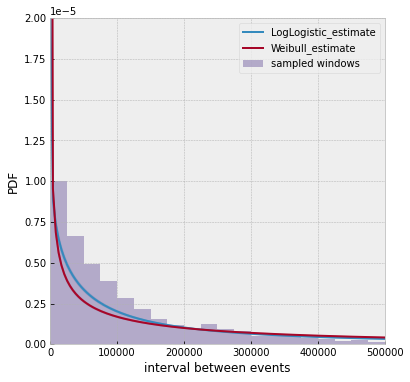

In [56]:
plt.figure(figsize=(6,6))


model_ll_sampled.plot_density()
model_wb_sampled.plot_density()
sample_windows[sample_windows.observed].tte.plot(kind="hist", density=True, range=(0, 5e5), bins=20, label="sampled windows", legend=True, alpha=0.5)

plt.xlim(0, 5e5)
plt.ylim(0, 2e-5)

plt.xlabel("interval between events")
plt.ylabel("PDF")


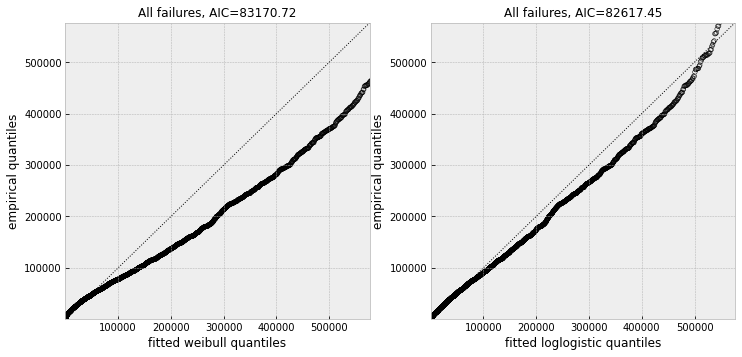

In [57]:
plt.figure(figsize=(12,12))

for i, (model_name, model) in enumerate(zip(["Weibull", "log-logistic"],
                                            [model_wb_sampled, model_ll_sampled])):
    plt.subplot(2,2,i+1)
    qq_plot(model, label="Weibull", ax=plt.gca())
    plt.title(f"All failures, AIC={model.AIC_:.2f}", fontsize=12)
plt.show()

## Features

In [58]:
features.head()

,Tool,stage,Lot,runnum,recipe,recipe_step,IONGAUGEPRESSURE,ETCHBEAMVOLTAGE,ETCHBEAMCURRENT,ETCHSUPPRESSORVOLTAGE,...,ETCHGASCHANNEL1READBACK,ETCHPBNGASREADBACK,FIXTURETILTANGLE,ROTATIONSPEED,ACTUALROTATIONANGLE,FIXTURESHUTTERPOSITION,ETCHSOURCEUSAGE,ETCHAUXSOURCETIMER,ETCHAUX2SOURCETIMER,ACTUALSTEPDURATION
time,,,,,,,,,,,,,,,,,,,,,
3284714,03M02,1,640,10511726,249,1,-1.547961,-1.222222,-1.272007,-1.468476,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975
3284720,03M02,1,640,10511726,249,1,-1.547446,-1.221113,-1.272404,-1.468567,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975
3284722,03M02,1,640,10511726,249,1,-1.546922,-1.221020,-1.272007,-1.468522,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975
3284726,03M02,1,640,10511726,249,1,-1.547770,-1.221205,-1.271928,-1.468567,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975
3284730,03M02,1,640,10511726,249,1,-1.548045,-1.222407,-1.271769,-1.468522,...,-1.575525,-1.601477,1.363214,-0.00277,-0.178652,0,0.471536,-0.811703,-0.217482,1.772975


In [59]:
NUM_FTS = ['IONGAUGEPRESSURE', 'ETCHBEAMVOLTAGE', 'ETCHBEAMCURRENT',
           'ETCHSUPPRESSORVOLTAGE', 'ETCHSUPPRESSORCURRENT', 'FLOWCOOLFLOWRATE',
           'FLOWCOOLPRESSURE', 'ETCHGASCHANNEL1READBACK', 'ETCHPBNGASREADBACK',
           'FIXTURETILTANGLE', 'ROTATIONSPEED']

In [60]:
def get_features(sample, ts):
    """Calculate features for a sample."""

    num_fts = (ts.loc[sample.start:sample.end, NUM_FTS]
               .agg(["mean", "max", "std", "min"])
               .unstack())
    num_fts.index = [f"{idx[0]}_{idx[1]}" for idx in num_fts.index]

    num_stages_since_start = ts.loc[sample.time_left:sample.end, "stage"].unique().shape[0]
    num_fts["num_stages"] = num_stages_since_start

    num_recipes_since_start = ts.loc[sample.time_left:sample.end, "recipe"].unique().shape[0]
    num_fts["num_recipes"] = num_recipes_since_start
    
    return num_fts

In [61]:
get_features(sample_windows.iloc[0], features)

IONGAUGEPRESSURE_mean           0.065059
IONGAUGEPRESSURE_max            0.829553
IONGAUGEPRESSURE_std            0.784259
IONGAUGEPRESSURE_min           -1.547129
ETCHBEAMVOLTAGE_mean           -0.334835
ETCHBEAMVOLTAGE_max             0.718236
ETCHBEAMVOLTAGE_std             0.477464
ETCHBEAMVOLTAGE_min            -1.223147
ETCHBEAMCURRENT_mean           -0.185031
ETCHBEAMCURRENT_max             3.929197
ETCHBEAMCURRENT_std             0.729849
ETCHBEAMCURRENT_min            -1.273119
ETCHSUPPRESSORVOLTAGE_mean      0.375355
ETCHSUPPRESSORVOLTAGE_max       0.931220
ETCHSUPPRESSORVOLTAGE_std       0.997380
ETCHSUPPRESSORVOLTAGE_min      -1.468340
ETCHSUPPRESSORCURRENT_mean     -0.094518
ETCHSUPPRESSORCURRENT_max       0.450945
ETCHSUPPRESSORCURRENT_std       0.763555
ETCHSUPPRESSORCURRENT_min      -1.416772
FLOWCOOLFLOWRATE_mean           0.112701
FLOWCOOLFLOWRATE_max            0.963862
FLOWCOOLFLOWRATE_std            0.914993
FLOWCOOLFLOWRATE_min           -1.900911
FLOWCOOLPRESSURE

In [62]:
sample_features = sample_windows.apply(lambda row: get_features(row, features), axis=1)

In [63]:
sample_features = (sample_features - sample_features.mean()) / sample_features.std()

In [64]:
samples = sample_windows.join(sample_features)
samples["previous"] = (samples.fault_name_left=="FlowCool Pressure Dropped Below Limit").astype(int)

In [65]:
samples

,start,end,session_id,time_left,fault_name_left,time_right,fault_name_right,age,tte,observed,...,FIXTURETILTANGLE_max,FIXTURETILTANGLE_std,FIXTURETILTANGLE_min,ROTATIONSPEED_mean,ROTATIONSPEED_max,ROTATIONSPEED_std,ROTATIONSPEED_min,num_stages,num_recipes,previous
0,29365904,29375904,266,29345754,FlowCool Pressure Dropped Below Limit,29615618,Flowcool Pressure Too High Check Flowcool Pump,20150,239714,False,...,-0.088423,-0.018974,0.547069,-0.002457,-0.014746,-0.020329,0.014746,-0.974674,-1.317763,1
1,15440558,15450558,70,15386092,FlowCool Pressure Dropped Below Limit,15553226,FlowCool Pressure Dropped Below Limit,54466,102668,True,...,-0.088423,0.138885,-0.598052,-0.002457,-0.014746,-0.020329,0.014746,-0.783938,-0.602391,1
2,18667910,18677910,89,18644314,FlowCool Pressure Dropped Below Limit,18840778,FlowCool Pressure Dropped Below Limit,23596,162868,True,...,-0.088423,0.133033,-0.146944,-0.002457,-0.014746,-0.020329,0.014746,-0.640887,-0.840849,1
3,24602790,24612790,190,24576194,FlowCool Pressure Dropped Below Limit,24675716,FlowCool Pressure Dropped Below Limit,26596,62926,True,...,-0.088423,-0.173985,-0.320447,-0.002457,-0.014746,-0.020329,0.014746,-0.783938,-0.602391,1
4,33881688,33891688,310,33470894,FlowCool Pressure Dropped Below Limit,34874274,Flowcool Pressure Too High Check Flowcool Pump,410794,982586,False,...,-0.088423,-0.343943,-0.146944,-0.002457,-0.014746,-0.020329,0.014746,0.598895,0.351438,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,13415178,13425178,60,13374204,FlowCool Pressure Dropped Below Limit,13470176,FlowCool Pressure Dropped Below Limit,40974,44998,True,...,-0.088423,-0.257166,1.588087,-0.002457,-0.014746,-0.020329,0.014746,-0.926990,-0.840849,1
4996,22520914,22530914,141,22480712,FlowCool Pressure Dropped Below Limit,22564472,FlowCool Pressure Dropped Below Limit,40202,33558,True,...,-0.088423,0.307557,-0.632752,-0.002457,-0.014746,-0.020329,0.014746,-0.783938,-0.840849,1
4997,33530346,33540346,310,33470894,FlowCool Pressure Dropped Below Limit,34874274,Flowcool Pressure Too High Check Flowcool Pump,59452,1333928,False,...,-0.088423,-0.162674,0.026559,-0.002457,-0.014746,-0.020329,0.014746,-0.974674,-1.079306,1
4998,22328144,22338144,139,22248054,FlowCool Pressure Dropped Below Limit,22421116,FlowCool Pressure Dropped Below Limit,80090,82972,True,...,-0.088423,0.141963,-0.598052,-0.002457,-0.014746,-0.020329,0.014746,-0.307099,-0.125477,1


In [66]:
samples["age"] = (samples["age"] - samples["age"].mean()) / samples["age"].std()

In [67]:
FTS = ['age', 'tte', 'observed',
       'IONGAUGEPRESSURE_mean', 'IONGAUGEPRESSURE_max', 'IONGAUGEPRESSURE_std',
       'IONGAUGEPRESSURE_min', 'ETCHBEAMVOLTAGE_mean', 'ETCHBEAMVOLTAGE_max',
       'ETCHBEAMVOLTAGE_std', 'ETCHBEAMCURRENT_mean',
       'ETCHBEAMCURRENT_max', 'ETCHBEAMCURRENT_std', 'ETCHBEAMCURRENT_min',
       'ETCHSUPPRESSORVOLTAGE_mean', 'ETCHSUPPRESSORVOLTAGE_max',
       'ETCHSUPPRESSORVOLTAGE_std', 'ETCHSUPPRESSORVOLTAGE_min',
       'ETCHSUPPRESSORCURRENT_mean', 'ETCHSUPPRESSORCURRENT_max',
       'ETCHSUPPRESSORCURRENT_std', 'ETCHSUPPRESSORCURRENT_min',
       'FLOWCOOLFLOWRATE_mean', 'FLOWCOOLFLOWRATE_max', 'FLOWCOOLFLOWRATE_std',
       'FLOWCOOLFLOWRATE_min', 'FLOWCOOLPRESSURE_mean', 'FLOWCOOLPRESSURE_max',
       'FLOWCOOLPRESSURE_std', 'FLOWCOOLPRESSURE_min',
       'ETCHGASCHANNEL1READBACK_mean', 'ETCHGASCHANNEL1READBACK_max',
       'ETCHGASCHANNEL1READBACK_std', 'ETCHGASCHANNEL1READBACK_min',
       'ETCHPBNGASREADBACK_mean', 'ETCHPBNGASREADBACK_max',
       'ETCHPBNGASREADBACK_std', 'ETCHPBNGASREADBACK_min',
       'FIXTURETILTANGLE_mean', 'FIXTURETILTANGLE_max', 'FIXTURETILTANGLE_std',
       'FIXTURETILTANGLE_min', 'num_stages', 'num_recipes', 'previous']

## Model

In [68]:
model_cph = lifelines.CoxPHFitter()
model_cph.fit(samples[FTS], duration_col="tte", event_col="observed")

<lifelines.CoxPHFitter: fitted with 4599 total observations, 1534 right-censored observations>

In [69]:
model_cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4599 total observations, 1534 right-censored observations>
             duration col = 'tte'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 4599
number of events observed = 3065
   partial log-likelihood = -22526.71
         time fit was run = 2021-03-08 13:14:05 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                            
age                           -1.50       0.22       0.14            -1.77            -1.22                 0.17                 0.29
IONGAUGEPRESSURE_mean         -0.98       0.37       0.15            -1.28            -0.69                 0.28                 0.50
IONGAUGEPRESSURE_max           0.03       1.03       0.18            -0.31             0.37                 0.73                 1.45
IONGAUGEPRESSURE_std           0.06       1.06       0.20            -0.32             0.44                 0.72                 1.56
IONGAUGEPRESSURE_min           0.12       1.12       0.02             0.07             0.16                 1.07                 1.17
ETCHBEAMVOLTAGE_mean          -0.66       0.52       0.41            -1.46             0.14                 0.23                 1.15
ETCHBEAMVOLTAGE_max            0.03       1.03       0.06            -0.08             0.14                 0.92                 1.15
ETCHBEAMVOLTAGE_std           -0.35       0.70       0.15            -0.65            -0.06                 0.52                 0.95
ETCHBEAMCURRENT_mean           0.41       1.50       0.54            -0.65             1.46                 0.52                 4.31
ETCHBEAMCURRENT_max            0.04       1.04       0.08            -0.12             0.20                 0.89                 1.23
ETCHBEAMCURRENT_std            0.75       2.11       0.22             0.31             1.18                 1.36                 3.26
ETCHBEAMCURRENT_min           -0.01       0.99       0.17            -0.34             0.31                 0.71                 1.37
ETCHSUPPRESSORVOLTAGE_mean    -0.32       0.73       0.18            -0.67             0.03                 0.51                 1.03
ETCHSUPPRESSORVOLTAGE_max     -0.13       0.88       0.05            -0.23            -0.03                 0.79                 0.97
ETCHSUPPRESSORVOLTAGE_std      0.10       1.10       0.12            -0.14             0.34                 0.87                 1.40
ETCHSUPPRESSORVOLTAGE_min     -0.31       0.73       0.98            -2.24             1.61                 0.11                 5.01
ETCHSUPPRESSORCURRENT_mean     0.49       1.63       0.19             0.11             0.86                 1.11                 2.37
ETCHSUPPRESSORCURRENT_max      0.03       1.04       0.03            -0.02             0.09                 0.98                 1.09
ETCHSUPPRESSORCURRENT_std     -0.21       0.81       0.11            -0.43             0.01                 0.65                 1.01
ETCHSUPPRESSORCURRENT_min     -0.57       0.57       1.04            -2.60             1.47                 0.07                 4.35
FLOWCOOLFLOWRATE_mean          0.27       1.31       0.17            -0.06             0.59                 0.94                 1.81
FLOWCOOLFLOWRATE_max           0.12       1.13       0.03             0.05             0.19                 1.06                 1.21
FLOWCOOLFLOWRATE_std           0.57       1.77       0.12             0.34             0.80                 1.40                 2.23
FLOWCOOLFLOWRATE_min          -0.04       0.96       0.03            -0.10             0.01                 0.90                 1.01
FLOWCOOLPRESSURE_mean         -0.39       0.68       0.14            -0.66            -0.12                 0.52                 0.88
FLOWCOOLPRESSURE_

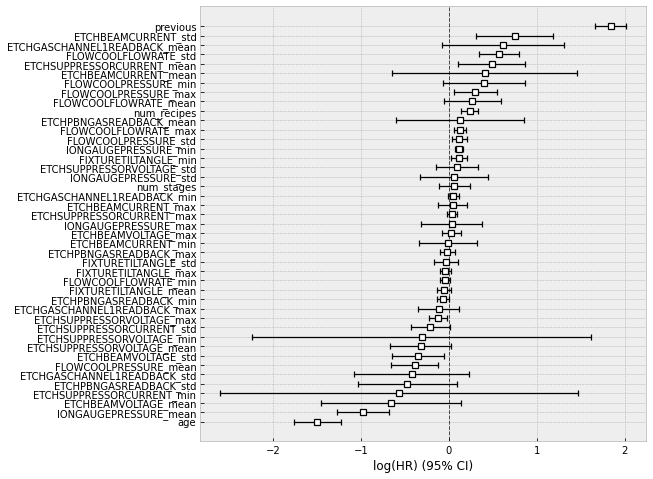

In [70]:
plt.figure(figsize=(8,8))
model_cph.plot()

In [71]:
model_cph.confidence_intervals_

,95% lower-bound,95% upper-bound
covariate,,
age,-1.765647,-1.224577
IONGAUGEPRESSURE_mean,-1.278152,-0.687202
IONGAUGEPRESSURE_max,-0.314500,0.373797
IONGAUGEPRESSURE_std,-0.324074,0.444480
IONGAUGEPRESSURE_min,0.069592,0.161184
ETCHBEAMVOLTAGE_mean,-1.455194,0.136851
ETCHBEAMVOLTAGE_max,-0.083467,0.137589
ETCHBEAMVOLTAGE_std,-0.651109,-0.056459
ETCHBEAMCURRENT_mean,-0.650292,1.461732


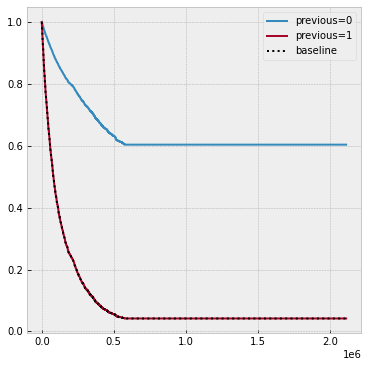

In [72]:
plt.figure(figsize=(6,6))

model_cph.plot_partial_effects_on_outcome("previous", [0, 1], ax=plt.gca())

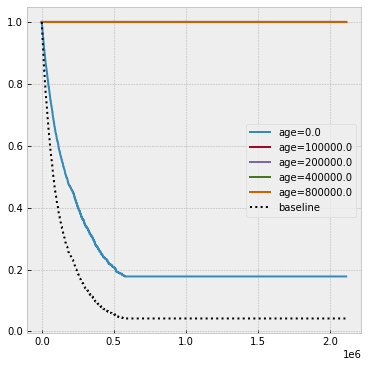

In [73]:
plt.figure(figsize=(6,6))

model_cph.plot_partial_effects_on_outcome("age", [0, 1e5, 2e5, 4e5, 8e5], ax=plt.gca())

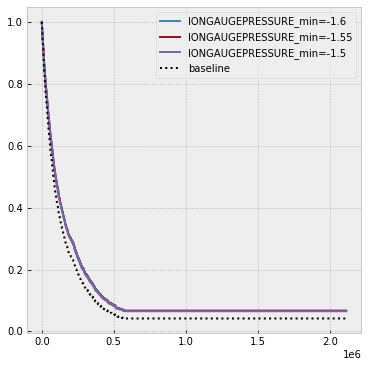

In [74]:
plt.figure(figsize=(6,6))

model_cph.plot_partial_effects_on_outcome("IONGAUGEPRESSURE_min", [-1.6, -1.55, -1.5], ax=plt.gca())

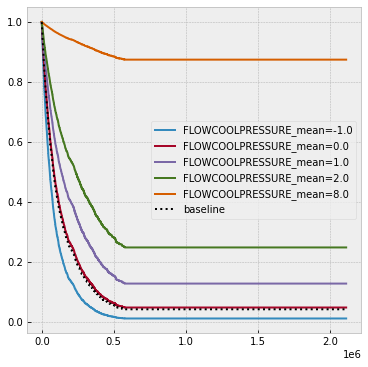

In [75]:
plt.figure(figsize=(6,6))

model_cph.plot_partial_effects_on_outcome("FLOWCOOLPRESSURE_mean", [-1., 0, 1, 2, 8], ax=plt.gca())

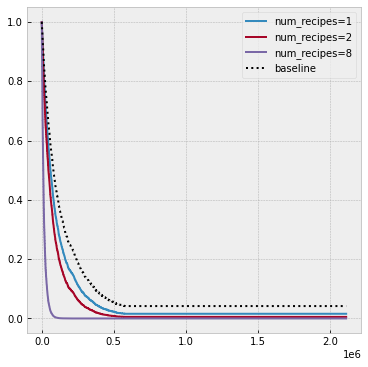

In [76]:
plt.figure(figsize=(6,6))

model_cph.plot_partial_effects_on_outcome("num_recipes", [1, 2, 8], ax=plt.gca())